In [29]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from pandas.plotting import lag_plot, scatter_matrix, autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests
import calendar
from datetime import datetime
pd.set_option("display.max_rows", 10)
import warnings
warnings.filterwarnings('ignore')

## Data Wrangling

Utilizaremos os dados da NASA de monitoramento da temperatura da superfície terrestre: https://data.giss.nasa.gov/gistemp/

E a média de CO2 detectado em amostras da atmosfera do Global Monitoring Laboratory do órgão de pesquisa americano NOAA em escala global: https://gml.noaa.gov/ \
Representando a soma de todo CO2 adicionado ou removido durante o ano por atividades humanas ou processos naturais.

In [2]:
raw_t = pd.read_csv('s3://sagemaker-leticia-croffi/data/GLB.Ts+dSST.csv', skiprows=1)
raw_e = pd.read_csv('s3://sagemaker-leticia-croffi/data/co2_mm_gl.csv')

### Alterações Climáticas

In [3]:
# Criando um novo dataframe com um index para cada mês
# Primeiro o alcance das datas é definido
date_rng = pd.date_range(start='1/1/1880', end='1/07/2022', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# Criando um DataFrame vazio que será preenchido com os dados de fato
t = pd.DataFrame(date_rng, columns=['date'])

# Criando uma coluna para os valores das anomalias de temperatura
t['anomalias'] = None

# Configurando o index do DataFrame na coluna de data (DateTime index)
t.set_index('date', inplace=True)

# Selecionando apenas os dados mensais, deixando as colunas sazonais
raw_t = raw_t.iloc[:,:13]

In [4]:
# Importando bibliotecas necessárias
import calendar
from datetime import datetime

# Definindo uma função
def populate_df_with_anomalies_from_row(row):
    year = row['Year']
    # Valores de anomalia de temperaturas
    monthly_anomalies = row.iloc[1:]
    # Meses abreviados (nomes no index)
    months = monthly_anomalies.index
    for month in monthly_anomalies.index:
        # Selecionando o último dia de cada mês
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construindo o index para referenciar o novo DataFrame para preenchimento 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # Preenchendo o valor correspondente a cada index
        t.loc[date_index] = monthly_anomalies[month]

# Aplicar a função em cada linha dos dados
_ = raw_t.apply(lambda row: populate_df_with_anomalies_from_row(row), axis=1)

In [5]:
# Definir a função para converter os valores para float e retornar 'NaN = Not a Number' quando não for possível
def clean_anomaly_value(raw_value):
    try:
        return float(raw_value)
    except:
        return np.NaN
    
# Aplicando a função em todos os valores do DataFrame
t['anomalias'] = t['anomalias'].apply(lambda raw_value: clean_anomaly_value(raw_value))

# 'Forward fill' para preencher valores NaN com os valores anteriores
t.fillna(method='ffill', inplace=True)

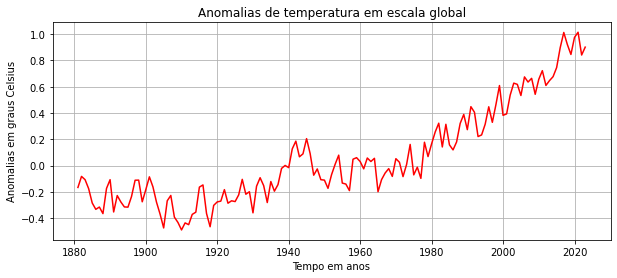

In [6]:
# Reamostragem dos dias para anos (último dia do ano)
t_resampled = t.resample('A').mean()

# Criando as figuras para plotar
fig, ax = plt.subplots(figsize=(10,4))

# Plotando a tempratura por data em uma cor específica e espessura de linha
ax.plot(t_resampled, color='red', linewidth=1.5)

# Configurando labels nos eixos e título do gráfico
ax.set(xlabel='Tempo em anos', ylabel='Anomalias em graus Celsius',
       title='Anomalias de temperatura em escala global')

# Habilitando grade
ax.grid()

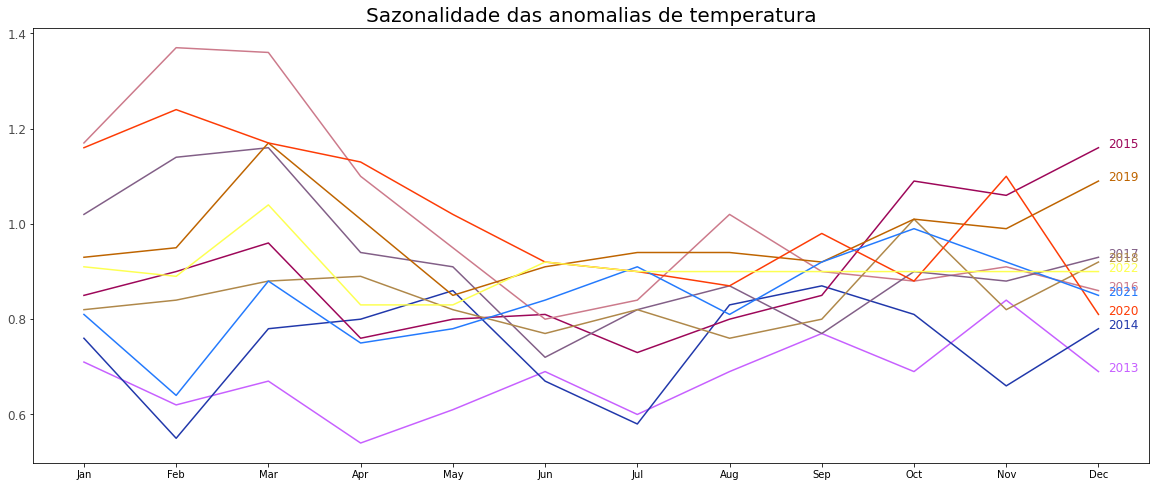

In [38]:
import matplotlib as mpl
temp = t[t.index >= pd.to_datetime('2012-01-01')]
temp['month'] = temp.index.strftime('%b')
temp['year'] = temp.index.year
years = temp['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(20,8))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'anomalias', data=temp.loc[temp.year==y, :], color=mycolors[i], label=y)
        plt.text(temp.loc[temp.year==y, :].shape[0]-.9, temp.loc[temp.year==y, 'anomalias'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.yticks(fontsize=12, alpha=.7)
plt.title("Sazonalidade das anomalias de temperatura", fontsize=20)
plt.show()

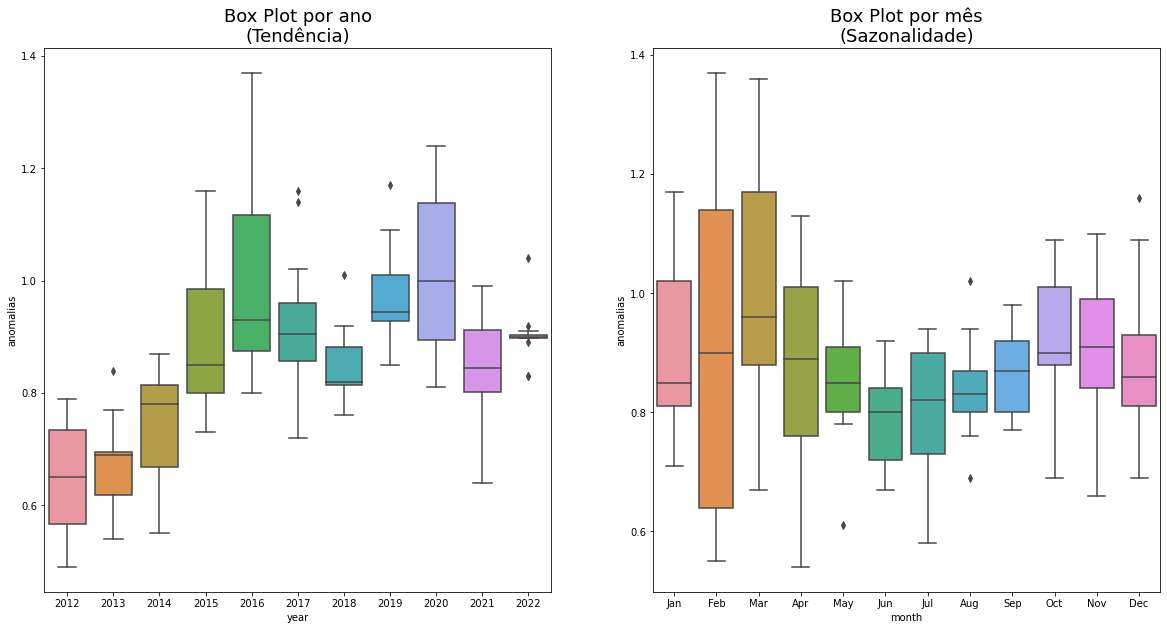

In [41]:
import seaborn as sns
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,10))
sns.boxplot(x='year', y='anomalias', data=temp, ax=axes[0])
sns.boxplot(x='month', y='anomalias', data=temp.loc[~temp.year.isin([2012, 2022]), :])

# Set Title
axes[0].set_title('Box Plot por ano\n(Tendência)', fontsize=18); 
axes[1].set_title('Box Plot por mês\n(Sazonalidade)', fontsize=18)
plt.show()

### Gás Carbônico (CO2)

In [52]:
# Criando um novo dataframe com um index para cada mês
# Primeiro o alcance das datas é definido
date_rng = pd.date_range(start='1/1/1980', end='1/05/2022', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# Criando um DataFrame vazio que será preenchido com os dados de fato
e = pd.DataFrame(date_rng, columns=['date'])

# Criando uma coluna para os valores das anomalias de temperatura
e['ppm'] = None

# Configurando o index do DataFrame na coluna de data (DateTime index)
e = e.set_index('date').asfreq('M')

# Utilizando apenas a média ppm (partes por milhão)
raw_e = raw_e[['year','month','average']]

In [53]:
def populate_df_with_ppm_from_row(row):
    year = int(row['year'])
    month = int(row['month'])
    monthly_ppm = row['average']
    last_day = calendar.monthrange(year,month)[1]
    date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %m %d')
    e.loc[date_index] = monthly_ppm

# Aplicar a função em cada linha dos dados
_ = raw_e.apply(lambda row: populate_df_with_ppm_from_row(row), axis=1)

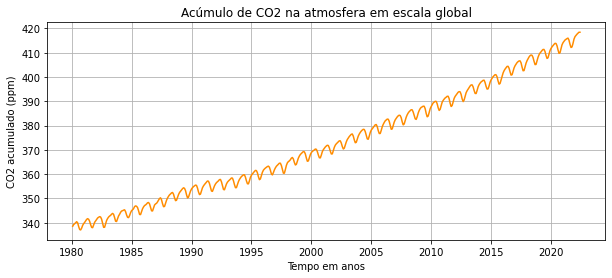

In [54]:
# Criando as figuras para plotar
fig, ax = plt.subplots(figsize=(10,4))

# Plotando o CO2 acumulado por data em uma cor específica e espessura de linha
ax.plot(e, color='darkorange', linewidth=1.5)

# Configurando labels nos eixos e título do gráfico
ax.set(xlabel='Tempo em anos', ylabel='CO2 acumulado (ppm)',
       title='Acúmulo de CO2 na atmosfera em escala global')

# Habilitando grade
ax.grid()

## Decomposição de série temporal

In [44]:
t_sample = t[t.index > pd.to_datetime('1989-12-31')]

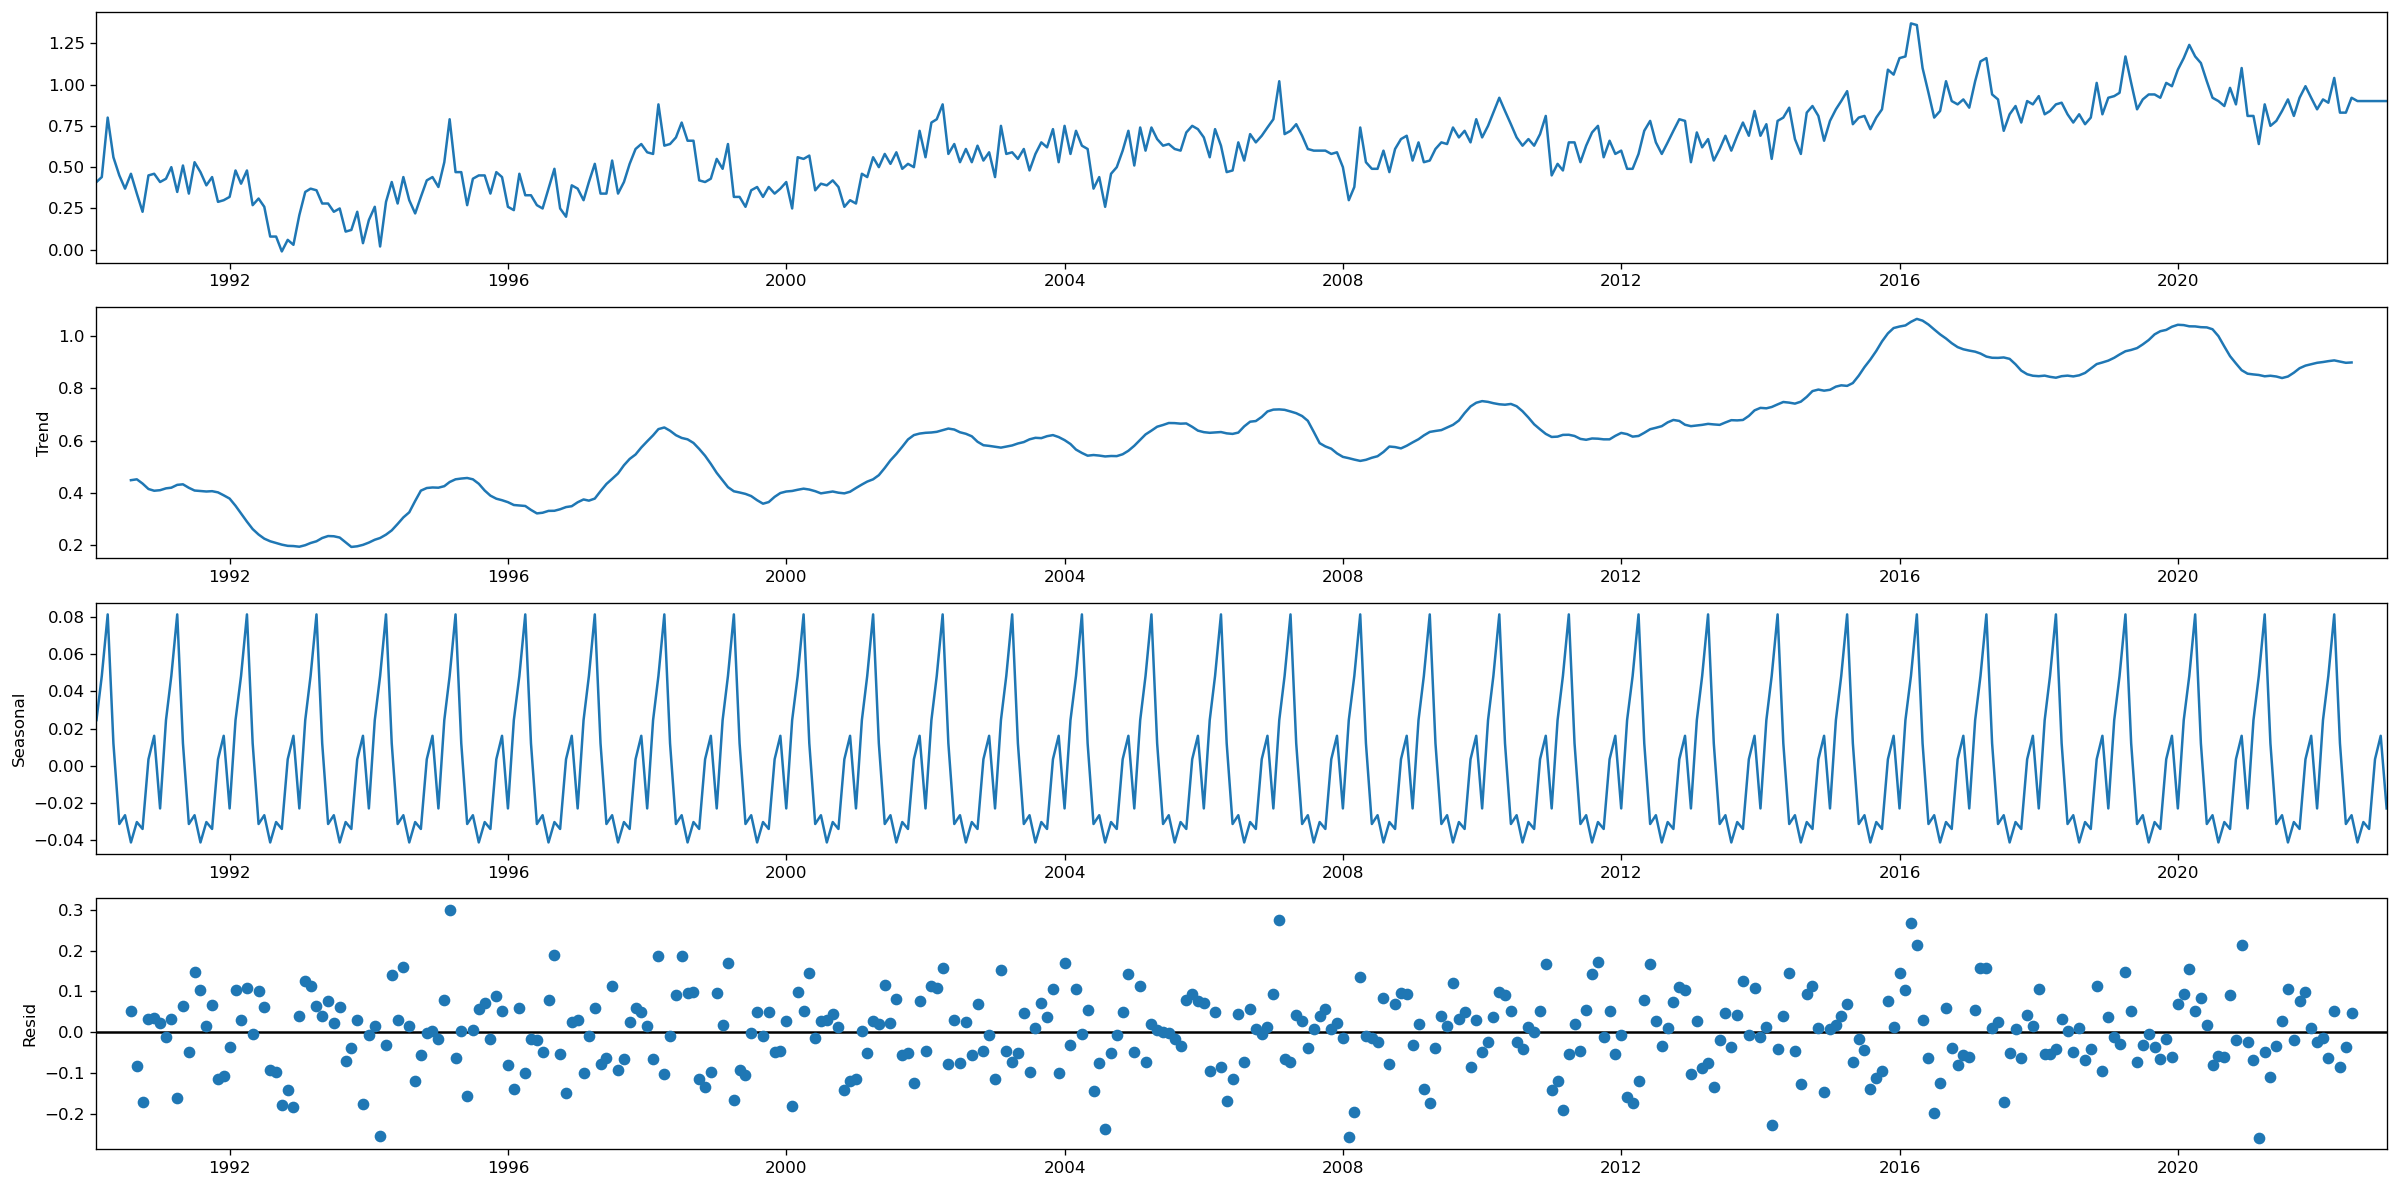

In [37]:
plt.rcParams.update({'figure.figsize':(20,10), 'figure.dpi':120})
result = seasonal_decompose(t_sample, model='additive')
result.plot()
plt.show()

## Teste de Hipótese Granger de Causalidade

In [55]:
data=t.reset_index().merge(e.reset_index(), on='date')

In [64]:
grangercausalitytests(data[['anomalias', 'ppm']], maxlag=[72])


Granger Causality
number of lags (no zero) 72
ssr based F test:         F=1.4567  , p=0.0166  , df_denom=292, df_num=72
ssr based chi2 test:   chi2=156.9602, p=0.0000  , df=72
likelihood ratio test: chi2=134.1062, p=0.0000  , df=72
parameter F test:         F=1.4567  , p=0.0166  , df_denom=292, df_num=72


{72: ({'ssr_ftest': (1.4566613100490005, 0.01656504848141337, 292.0, 72),
   'ssr_chi2test': (156.9602447239101, 2.9372655164650192e-08, 72),
   'lrtest': (134.10620775748112, 1.2506712852333962e-05, 72),
   'params_ftest': (1.4566613100472838, 0.01656504848169328, 292.0, 72.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

In [63]:
grangercausalitytests(data[['ppm', 'anomalias']], maxlag=[72])


Granger Causality
number of lags (no zero) 72
ssr based F test:         F=1.3461  , p=0.0466  , df_denom=292, df_num=72
ssr based chi2 test:   chi2=145.0446, p=0.0000  , df=72
likelihood ratio test: chi2=125.2503, p=0.0001  , df=72
parameter F test:         F=1.3461  , p=0.0466  , df_denom=292, df_num=72


{72: ({'ssr_ftest': (1.3460789032957299, 0.046578078472185855, 292.0, 72),
   'ssr_chi2test': (145.04461168937274, 7.632507806448047e-07, 72),
   'lrtest': (125.25027521133825, 0.00010294267261426632, 72),
   'params_ftest': (1.346078903297888, 0.04657807847129839, 292.0, 72.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

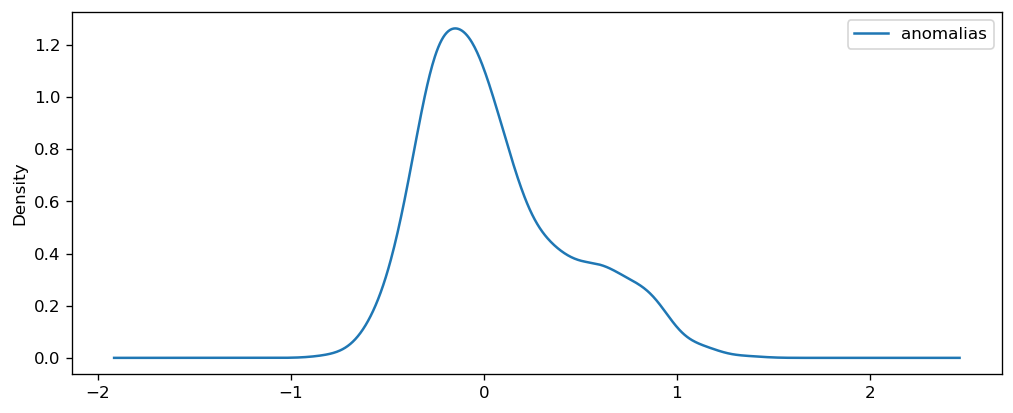

In [40]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
t.plot(kind='kde')
plt.show()

## Lag Plots
Para verificar autocorrelação

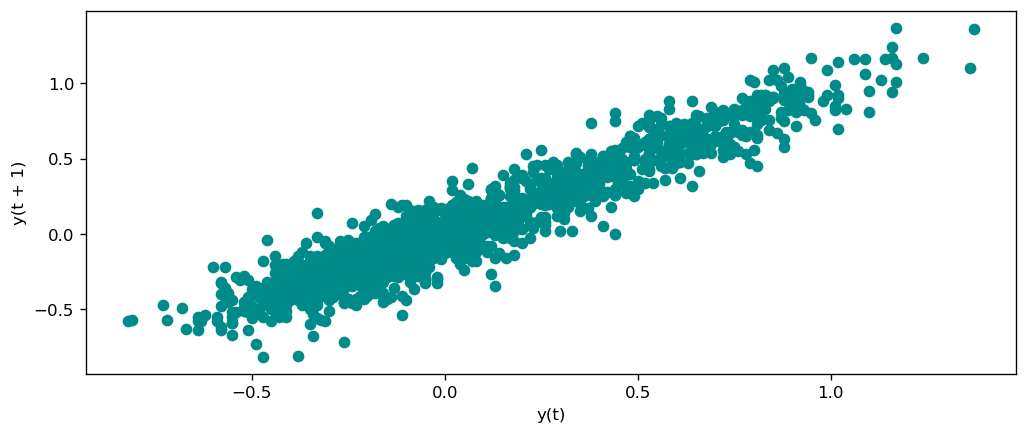

In [42]:
lag_plot(t, c='darkcyan')
plt.show()

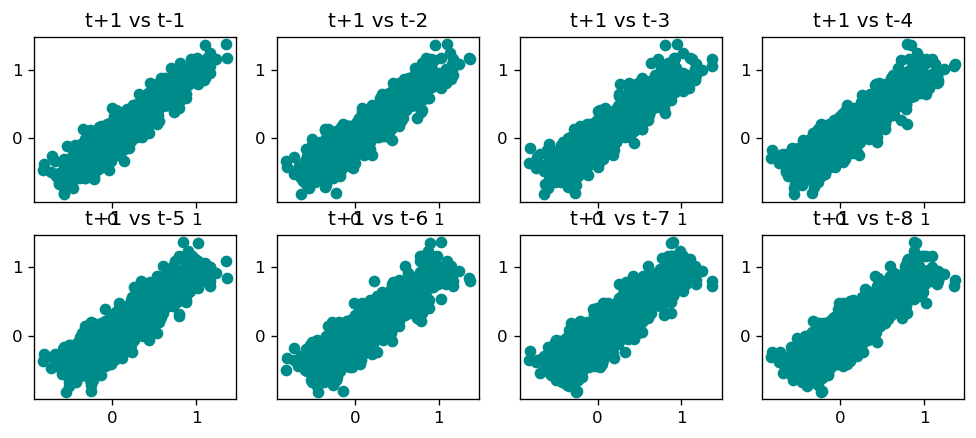

In [43]:
values = pd.DataFrame(t.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values, c='darkcyan')
plt.show()

## Autocorrelação
Picos recorrentes nesse gráfico podem ser um indicativo de sazonalidade.

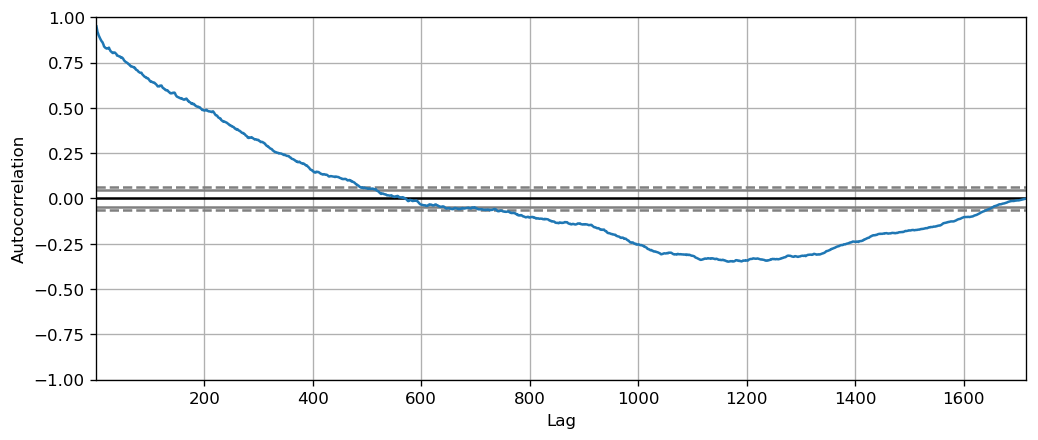

In [44]:
autocorrelation_plot(t.dropna())
plt.show()

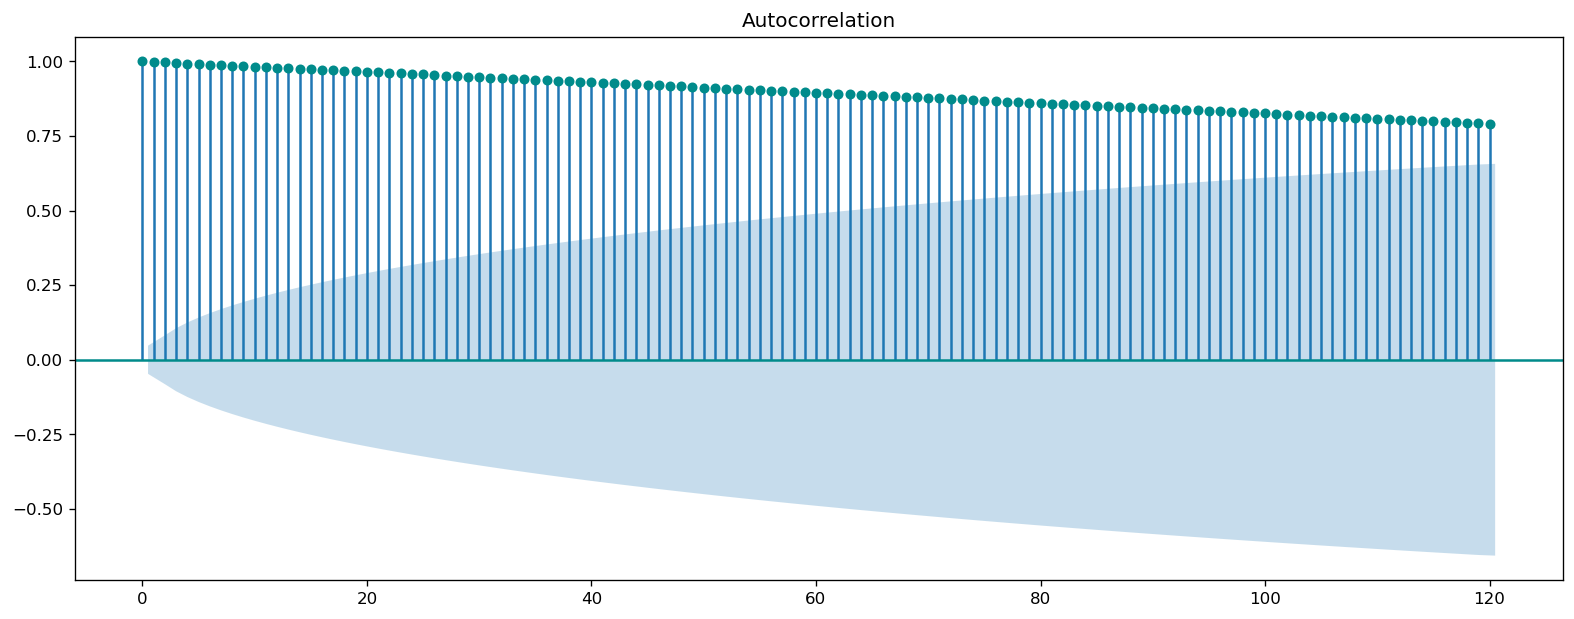

In [45]:
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':120})
plot_acf(x=t.index,lags=120, color='darkcyan')
plt.show()

## Teste de Hipótese Dickey-Fuller aumentado
Testa se a série temporal é estacionária

In [47]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(t.dropna().anomalias)
# differencing (d)
# Se P Value < 0.05 a série temporal é estacionária
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.561011
p-value: 0.879551


## Entropia Aproximada
Testa a imprevisibilidade e a regularidade da série temporal. Em comparação com séries temporais aleatórias, quanto mais alto o valor, pior.

In [49]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Calcula Entropia Aproximada"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(t.anomalias, m=2, r=0.2*np.std(t.anomalias)))
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small)))
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))

1.0561002044738412
0.08867274083524546
0.7381644774490885


## Entropia Amostral
A entropia amostral é similar a entropia aproximada, mas é mais consistente em estimar a complexidade para séries temporais menores. Por exemplo, uma série temporal aleatória com menos pontos pode ter uma entropia aproximada mais baixa que uma série temporal regular, já uma série temporal aleatória mais longa terá uma entropia aproximada mais alta.

In [50]:
def SampEn(U, m, r):
    """Calcular Entropia Amostral"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(t.anomalias, m=2, r=0.2*np.std(t.anomalias)))
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))

0.95304180043012
1.3862943611198906
2.063693184711697
